In [1]:
do_sim <- function(n_sim = 1000, n_t = 1000, my_garch, df_prices) {
  require(tidyverse)
  require(rugarch)
  
  do_single_sim <- function(i_sim, n_t, my_garch, df_prices) {
    
    
    message('Simulation ', i_sim)
    
    rugarch_sim = ugarchsim(my_garch, n.sim = n_t, 
                            m.sim = 1)
    
    sim_series <- rugarch_sim@simulation$seriesSim
    
    df_sim_out <- tibble(i_sim = i_sim, 
                         i_t = 0:length(sim_series),
                         ref_date = last(df_prices$ref.date) + i_t,
                         sim_log_ret = c(0, sim_series), # model was estimated on log returns
                         sim_arit_ret = exp(sim_log_ret)-1, # use arit return for price calc
                         sim_price = last(df_prices$price.adjusted)*(cumprod(1+sim_arit_ret)) )
    
    return(df_sim_out) 
  }
  
  df_out <- bind_rows(map(.x = 1:n_sim, 
                          .f = do_single_sim, 
                          my_garch = my_garch, 
                          n_t = n_t,
                          df_prices=df_prices))
  
  
}

In [2]:
do_single_garch <- function(x, 
                            type_model, 
                            type_dist, 
                            lag_ar, 
                            lag_ma, 
                            lag_arch, 
                            lag_garch) {
  require(rugarch)
  
  
  spec = ugarchspec(variance.model = list(model =  type_model, 
                                          garchOrder = c(lag_arch, lag_garch)),
                    mean.model = list(armaOrder = c(lag_ar, lag_ma)),
                    distribution = type_dist)
  
  message('Estimating ARMA(',lag_ar, ',', lag_ma,')-',
          type_model, '(', lag_arch, ',', lag_garch, ')', 
          ' dist = ', type_dist,
          appendLF = FALSE)
  
  try({
    my_rugarch <- list()
    my_rugarch <- ugarchfit(spec = spec, data = x)
  })
  
  if (!is.null(coef(my_rugarch))) {
    message('\tDone')
    
    AIC <- rugarch::infocriteria(my_rugarch)[1]
    BIC <- rugarch::infocriteria(my_rugarch)[2]
  } else {
    message('\tEstimation failed..')
    
    AIC <- NA
    BIC <- NA
  }

  est_tab <- tibble(lag_ar, 
                    lag_ma,
                    lag_arch,
                    lag_garch,
                    AIC =  AIC,
                    BIC = BIC,
                    type_model = type_model,
                    type_dist,
                    model_name = paste0('ARMA(', lag_ar, ',', lag_ma, ')+',
                                        type_model, '(', lag_arch, ',', lag_garch, ') ',
                                        type_dist) ) 
  
  return(est_tab)
}

In [3]:
find_best_arch_model <- function(x, 
                                 type_models, 
                                 dist_to_use,
                                 max_lag_AR,
                                 max_lag_MA,
                                 max_lag_ARCH,
                                 max_lag_GARCH) {
  
  require(tidyr)
  
  df_grid <- expand_grid(type_models = type_models,
                         dist_to_use = dist_to_use,
                         arma_lag = 0:max_lag_AR,
                         ma_lag = 0:max_lag_MA,
                         arch_lag = 1:max_lag_ARCH,
                         garch_lag = 1:max_lag_GARCH)
  
  
  l_out <- pmap(.l = list(x = rep(list(x), nrow(df_grid)), 
                          type_model = df_grid$type_models,
                          type_dist = df_grid$dist_to_use,
                          lag_ar = df_grid$arma_lag,
                          lag_ma = df_grid$ma_lag,
                          lag_arch = df_grid$arch_lag,
                          lag_garch  = df_grid$garch_lag),
                do_single_garch)
  
  tab_out <- bind_rows(l_out)
  
  # find by AIC
  idx <- which.min(tab_out$AIC)
  best_aic <- tab_out[idx, ]
  
  # find by BIC
  idx <- which.min(tab_out$BIC)
  best_bic <- tab_out[idx, ]
  
  l_out <- list(best_aic = best_aic,
                best_bic = best_bic,
                tab_out = tab_out)
  
  return(l_out)
}

In [4]:
suppressPackageStartupMessages({library(tidyquant)
library(tidyverse)
})
options(warn = -1)

In [29]:
acao <- "BRML3.SA"
ibov <- tq_get(acao, from = "2000-01-01")
ret <- ibov %>%
  tq_transmute(select = close, mutate_fun = dailyReturn)
ret_l <- ibov %>%
  tq_transmute(select = close, mutate_fun = dailyReturn, type = "log")
colnames(ret_l) <- c("date", "log_return")
ibov1 <- left_join(ret, ibov, by = c("date" = "date"))
ibov1 <- left_join(ibov1, ret_l, by = c("date" = "date"))
ibov1 <- ibov1 %>%
  group_by(date, symbol) %>%
  summarise(adjusted, log_return, daily.returns) %>%
  mutate(series_name = acao)
colnames(ibov1) <- c("ref.date","ticker","price.adjusted","log_ret","arim_ret","series_name")

`summarise()` regrouping output by 'date' (override with `.groups` argument)



In [30]:
arch <- find_best_arch_model(ibov1$log_ret,
                             type_models = c("sGARCH"),
                             dist_to_use = c("norm","snorm"),
                             max_lag_AR = 2,
                             max_lag_MA = 2,
                             max_lag_ARCH = 2,
                             max_lag_GARCH = 2)

Estimating ARMA(0,0)-sGARCH(1,1) dist = norm
	Done

Estimating ARMA(0,0)-sGARCH(1,2) dist = norm
	Done

Estimating ARMA(0,0)-sGARCH(2,1) dist = norm
	Done

Estimating ARMA(0,0)-sGARCH(2,2) dist = norm
	Done

Estimating ARMA(0,1)-sGARCH(1,1) dist = norm
	Done

Estimating ARMA(0,1)-sGARCH(1,2) dist = norm
	Done

Estimating ARMA(0,1)-sGARCH(2,1) dist = norm
	Done

Estimating ARMA(0,1)-sGARCH(2,2) dist = norm
	Done

Estimating ARMA(0,2)-sGARCH(1,1) dist = norm
	Done

Estimating ARMA(0,2)-sGARCH(1,2) dist = norm
	Done

Estimating ARMA(0,2)-sGARCH(2,1) dist = norm
	Done

Estimating ARMA(0,2)-sGARCH(2,2) dist = norm
	Done

Estimating ARMA(1,0)-sGARCH(1,1) dist = norm
	Done

Estimating ARMA(1,0)-sGARCH(1,2) dist = norm
	Done

Estimating ARMA(1,0)-sGARCH(2,1) dist = norm
	Done

Estimating ARMA(1,0)-sGARCH(2,2) dist = norm
	Done

Estimating ARMA(1,1)-sGARCH(1,1) dist = norm
	Done

Estimating ARMA(1,1)-sGARCH(1,2) dist = norm
	Done

Estimating ARMA(1,1)-sGARCH(2,1) dist = norm
	Done

Estimating A

In [31]:
lag_ar_best <- arch$best_bic$lag_ar
lag_ma_best <- arch$best_bic$lag_ma
lag_arch_best <- arch$best_bic$lag_arch
lag_garch_best <- arch$best_bic$lag_garch
type <- arch$best_bic$type_model
dist <- arch$best_bic$type_dist

In [32]:
ugspec <- ugarchspec(variance.model = list(model = type,
                                           garchOrder = c(lag_arch_best, lag_garch_best)),
                     mean.model = list(armaOrder = c(lag_ar_best, lag_ma_best)),
                     distribution.model = dist)
ugfit <- ugarchfit(ugspec, ret$daily.returns)

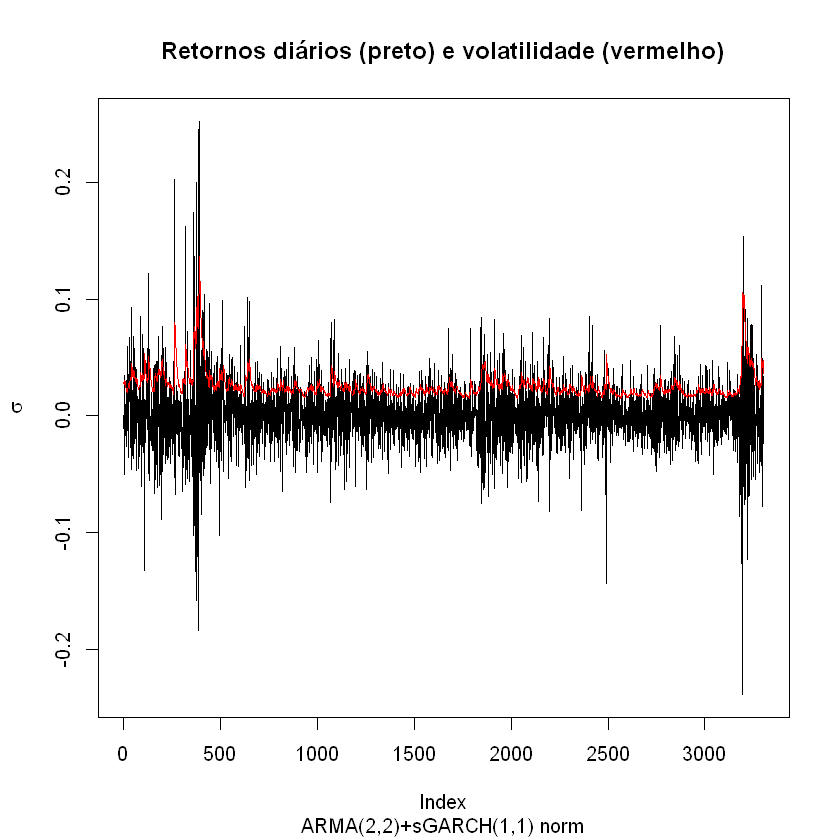

In [33]:
plot(ret$daily.returns, type = "l",
     ylab = expression(sigma),
     main = "Retornos diários (preto) e volatilidade (vermelho)",
    sub = paste(arch$best_aic$model_name))
lines(ugfit@fit$sigma, col = "red")

In [34]:
sim <- do_sim(n_sim = 6000, n_t = 365, my_garch = ugfit, df_prices = ibov1)

Simulation 1

Simulation 2

Simulation 3

Simulation 4

Simulation 5

Simulation 6

Simulation 7

Simulation 8

Simulation 9

Simulation 10

Simulation 11

Simulation 12

Simulation 13

Simulation 14

Simulation 15

Simulation 16

Simulation 17

Simulation 18

Simulation 19

Simulation 20

Simulation 21

Simulation 22

Simulation 23

Simulation 24

Simulation 25

Simulation 26

Simulation 27

Simulation 28

Simulation 29

Simulation 30

Simulation 31

Simulation 32

Simulation 33

Simulation 34

Simulation 35

Simulation 36

Simulation 37

Simulation 38

Simulation 39

Simulation 40

Simulation 41

Simulation 42

Simulation 43

Simulation 44

Simulation 45

Simulation 46

Simulation 47

Simulation 48

Simulation 49

Simulation 50

Simulation 51

Simulation 52

Simulation 53

Simulation 54

Simulation 55

Simulation 56

Simulation 57

Simulation 58

Simulation 59

Simulation 60

Simulation 61

Simulation 62

Simulation 63

Simulation 64

Simulation 65

Simulation 66

Simulation 67

Simu

Simulation 520

Simulation 521

Simulation 522

Simulation 523

Simulation 524

Simulation 525

Simulation 526

Simulation 527

Simulation 528

Simulation 529

Simulation 530

Simulation 531

Simulation 532

Simulation 533

Simulation 534

Simulation 535

Simulation 536

Simulation 537

Simulation 538

Simulation 539

Simulation 540

Simulation 541

Simulation 542

Simulation 543

Simulation 544

Simulation 545

Simulation 546

Simulation 547

Simulation 548

Simulation 549

Simulation 550

Simulation 551

Simulation 552

Simulation 553

Simulation 554

Simulation 555

Simulation 556

Simulation 557

Simulation 558

Simulation 559

Simulation 560

Simulation 561

Simulation 562

Simulation 563

Simulation 564

Simulation 565

Simulation 566

Simulation 567

Simulation 568

Simulation 569

Simulation 570

Simulation 571

Simulation 572

Simulation 573

Simulation 574

Simulation 575

Simulation 576

Simulation 577

Simulation 578

Simulation 579

Simulation 580

Simulation 581

Simulati

Simulation 1031

Simulation 1032

Simulation 1033

Simulation 1034

Simulation 1035

Simulation 1036

Simulation 1037

Simulation 1038

Simulation 1039

Simulation 1040

Simulation 1041

Simulation 1042

Simulation 1043

Simulation 1044

Simulation 1045

Simulation 1046

Simulation 1047

Simulation 1048

Simulation 1049

Simulation 1050

Simulation 1051

Simulation 1052

Simulation 1053

Simulation 1054

Simulation 1055

Simulation 1056

Simulation 1057

Simulation 1058

Simulation 1059

Simulation 1060

Simulation 1061

Simulation 1062

Simulation 1063

Simulation 1064

Simulation 1065

Simulation 1066

Simulation 1067

Simulation 1068

Simulation 1069

Simulation 1070

Simulation 1071

Simulation 1072

Simulation 1073

Simulation 1074

Simulation 1075

Simulation 1076

Simulation 1077

Simulation 1078

Simulation 1079

Simulation 1080

Simulation 1081

Simulation 1082

Simulation 1083

Simulation 1084

Simulation 1085

Simulation 1086

Simulation 1087

Simulation 1088

Simulation 108

Simulation 1513

Simulation 1514

Simulation 1515

Simulation 1516

Simulation 1517

Simulation 1518

Simulation 1519

Simulation 1520

Simulation 1521

Simulation 1522

Simulation 1523

Simulation 1524

Simulation 1525

Simulation 1526

Simulation 1527

Simulation 1528

Simulation 1529

Simulation 1530

Simulation 1531

Simulation 1532

Simulation 1533

Simulation 1534

Simulation 1535

Simulation 1536

Simulation 1537

Simulation 1538

Simulation 1539

Simulation 1540

Simulation 1541

Simulation 1542

Simulation 1543

Simulation 1544

Simulation 1545

Simulation 1546

Simulation 1547

Simulation 1548

Simulation 1549

Simulation 1550

Simulation 1551

Simulation 1552

Simulation 1553

Simulation 1554

Simulation 1555

Simulation 1556

Simulation 1557

Simulation 1558

Simulation 1559

Simulation 1560

Simulation 1561

Simulation 1562

Simulation 1563

Simulation 1564

Simulation 1565

Simulation 1566

Simulation 1567

Simulation 1568

Simulation 1569

Simulation 1570

Simulation 157

Simulation 1995

Simulation 1996

Simulation 1997

Simulation 1998

Simulation 1999

Simulation 2000

Simulation 2001

Simulation 2002

Simulation 2003

Simulation 2004

Simulation 2005

Simulation 2006

Simulation 2007

Simulation 2008

Simulation 2009

Simulation 2010

Simulation 2011

Simulation 2012

Simulation 2013

Simulation 2014

Simulation 2015

Simulation 2016

Simulation 2017

Simulation 2018

Simulation 2019

Simulation 2020

Simulation 2021

Simulation 2022

Simulation 2023

Simulation 2024

Simulation 2025

Simulation 2026

Simulation 2027

Simulation 2028

Simulation 2029

Simulation 2030

Simulation 2031

Simulation 2032

Simulation 2033

Simulation 2034

Simulation 2035

Simulation 2036

Simulation 2037

Simulation 2038

Simulation 2039

Simulation 2040

Simulation 2041

Simulation 2042

Simulation 2043

Simulation 2044

Simulation 2045

Simulation 2046

Simulation 2047

Simulation 2048

Simulation 2049

Simulation 2050

Simulation 2051

Simulation 2052

Simulation 205

Simulation 2477

Simulation 2478

Simulation 2479

Simulation 2480

Simulation 2481

Simulation 2482

Simulation 2483

Simulation 2484

Simulation 2485

Simulation 2486

Simulation 2487

Simulation 2488

Simulation 2489

Simulation 2490

Simulation 2491

Simulation 2492

Simulation 2493

Simulation 2494

Simulation 2495

Simulation 2496

Simulation 2497

Simulation 2498

Simulation 2499

Simulation 2500

Simulation 2501

Simulation 2502

Simulation 2503

Simulation 2504

Simulation 2505

Simulation 2506

Simulation 2507

Simulation 2508

Simulation 2509

Simulation 2510

Simulation 2511

Simulation 2512

Simulation 2513

Simulation 2514

Simulation 2515

Simulation 2516

Simulation 2517

Simulation 2518

Simulation 2519

Simulation 2520

Simulation 2521

Simulation 2522

Simulation 2523

Simulation 2524

Simulation 2525

Simulation 2526

Simulation 2527

Simulation 2528

Simulation 2529

Simulation 2530

Simulation 2531

Simulation 2532

Simulation 2533

Simulation 2534

Simulation 253

Simulation 2959

Simulation 2960

Simulation 2961

Simulation 2962

Simulation 2963

Simulation 2964

Simulation 2965

Simulation 2966

Simulation 2967

Simulation 2968

Simulation 2969

Simulation 2970

Simulation 2971

Simulation 2972

Simulation 2973

Simulation 2974

Simulation 2975

Simulation 2976

Simulation 2977

Simulation 2978

Simulation 2979

Simulation 2980

Simulation 2981

Simulation 2982

Simulation 2983

Simulation 2984

Simulation 2985

Simulation 2986

Simulation 2987

Simulation 2988

Simulation 2989

Simulation 2990

Simulation 2991

Simulation 2992

Simulation 2993

Simulation 2994

Simulation 2995

Simulation 2996

Simulation 2997

Simulation 2998

Simulation 2999

Simulation 3000

Simulation 3001

Simulation 3002

Simulation 3003

Simulation 3004

Simulation 3005

Simulation 3006

Simulation 3007

Simulation 3008

Simulation 3009

Simulation 3010

Simulation 3011

Simulation 3012

Simulation 3013

Simulation 3014

Simulation 3015

Simulation 3016

Simulation 301

Simulation 3441

Simulation 3442

Simulation 3443

Simulation 3444

Simulation 3445

Simulation 3446

Simulation 3447

Simulation 3448

Simulation 3449

Simulation 3450

Simulation 3451

Simulation 3452

Simulation 3453

Simulation 3454

Simulation 3455

Simulation 3456

Simulation 3457

Simulation 3458

Simulation 3459

Simulation 3460

Simulation 3461

Simulation 3462

Simulation 3463

Simulation 3464

Simulation 3465

Simulation 3466

Simulation 3467

Simulation 3468

Simulation 3469

Simulation 3470

Simulation 3471

Simulation 3472

Simulation 3473

Simulation 3474

Simulation 3475

Simulation 3476

Simulation 3477

Simulation 3478

Simulation 3479

Simulation 3480

Simulation 3481

Simulation 3482

Simulation 3483

Simulation 3484

Simulation 3485

Simulation 3486

Simulation 3487

Simulation 3488

Simulation 3489

Simulation 3490

Simulation 3491

Simulation 3492

Simulation 3493

Simulation 3494

Simulation 3495

Simulation 3496

Simulation 3497

Simulation 3498

Simulation 349

Simulation 3923

Simulation 3924

Simulation 3925

Simulation 3926

Simulation 3927

Simulation 3928

Simulation 3929

Simulation 3930

Simulation 3931

Simulation 3932

Simulation 3933

Simulation 3934

Simulation 3935

Simulation 3936

Simulation 3937

Simulation 3938

Simulation 3939

Simulation 3940

Simulation 3941

Simulation 3942

Simulation 3943

Simulation 3944

Simulation 3945

Simulation 3946

Simulation 3947

Simulation 3948

Simulation 3949

Simulation 3950

Simulation 3951

Simulation 3952

Simulation 3953

Simulation 3954

Simulation 3955

Simulation 3956

Simulation 3957

Simulation 3958

Simulation 3959

Simulation 3960

Simulation 3961

Simulation 3962

Simulation 3963

Simulation 3964

Simulation 3965

Simulation 3966

Simulation 3967

Simulation 3968

Simulation 3969

Simulation 3970

Simulation 3971

Simulation 3972

Simulation 3973

Simulation 3974

Simulation 3975

Simulation 3976

Simulation 3977

Simulation 3978

Simulation 3979

Simulation 3980

Simulation 398

Simulation 4405

Simulation 4406

Simulation 4407

Simulation 4408

Simulation 4409

Simulation 4410

Simulation 4411

Simulation 4412

Simulation 4413

Simulation 4414

Simulation 4415

Simulation 4416

Simulation 4417

Simulation 4418

Simulation 4419

Simulation 4420

Simulation 4421

Simulation 4422

Simulation 4423

Simulation 4424

Simulation 4425

Simulation 4426

Simulation 4427

Simulation 4428

Simulation 4429

Simulation 4430

Simulation 4431

Simulation 4432

Simulation 4433

Simulation 4434

Simulation 4435

Simulation 4436

Simulation 4437

Simulation 4438

Simulation 4439

Simulation 4440

Simulation 4441

Simulation 4442

Simulation 4443

Simulation 4444

Simulation 4445

Simulation 4446

Simulation 4447

Simulation 4448

Simulation 4449

Simulation 4450

Simulation 4451

Simulation 4452

Simulation 4453

Simulation 4454

Simulation 4455

Simulation 4456

Simulation 4457

Simulation 4458

Simulation 4459

Simulation 4460

Simulation 4461

Simulation 4462

Simulation 446

Simulation 4887

Simulation 4888

Simulation 4889

Simulation 4890

Simulation 4891

Simulation 4892

Simulation 4893

Simulation 4894

Simulation 4895

Simulation 4896

Simulation 4897

Simulation 4898

Simulation 4899

Simulation 4900

Simulation 4901

Simulation 4902

Simulation 4903

Simulation 4904

Simulation 4905

Simulation 4906

Simulation 4907

Simulation 4908

Simulation 4909

Simulation 4910

Simulation 4911

Simulation 4912

Simulation 4913

Simulation 4914

Simulation 4915

Simulation 4916

Simulation 4917

Simulation 4918

Simulation 4919

Simulation 4920

Simulation 4921

Simulation 4922

Simulation 4923

Simulation 4924

Simulation 4925

Simulation 4926

Simulation 4927

Simulation 4928

Simulation 4929

Simulation 4930

Simulation 4931

Simulation 4932

Simulation 4933

Simulation 4934

Simulation 4935

Simulation 4936

Simulation 4937

Simulation 4938

Simulation 4939

Simulation 4940

Simulation 4941

Simulation 4942

Simulation 4943

Simulation 4944

Simulation 494

Simulation 5369

Simulation 5370

Simulation 5371

Simulation 5372

Simulation 5373

Simulation 5374

Simulation 5375

Simulation 5376

Simulation 5377

Simulation 5378

Simulation 5379

Simulation 5380

Simulation 5381

Simulation 5382

Simulation 5383

Simulation 5384

Simulation 5385

Simulation 5386

Simulation 5387

Simulation 5388

Simulation 5389

Simulation 5390

Simulation 5391

Simulation 5392

Simulation 5393

Simulation 5394

Simulation 5395

Simulation 5396

Simulation 5397

Simulation 5398

Simulation 5399

Simulation 5400

Simulation 5401

Simulation 5402

Simulation 5403

Simulation 5404

Simulation 5405

Simulation 5406

Simulation 5407

Simulation 5408

Simulation 5409

Simulation 5410

Simulation 5411

Simulation 5412

Simulation 5413

Simulation 5414

Simulation 5415

Simulation 5416

Simulation 5417

Simulation 5418

Simulation 5419

Simulation 5420

Simulation 5421

Simulation 5422

Simulation 5423

Simulation 5424

Simulation 5425

Simulation 5426

Simulation 542

Simulation 5851

Simulation 5852

Simulation 5853

Simulation 5854

Simulation 5855

Simulation 5856

Simulation 5857

Simulation 5858

Simulation 5859

Simulation 5860

Simulation 5861

Simulation 5862

Simulation 5863

Simulation 5864

Simulation 5865

Simulation 5866

Simulation 5867

Simulation 5868

Simulation 5869

Simulation 5870

Simulation 5871

Simulation 5872

Simulation 5873

Simulation 5874

Simulation 5875

Simulation 5876

Simulation 5877

Simulation 5878

Simulation 5879

Simulation 5880

Simulation 5881

Simulation 5882

Simulation 5883

Simulation 5884

Simulation 5885

Simulation 5886

Simulation 5887

Simulation 5888

Simulation 5889

Simulation 5890

Simulation 5891

Simulation 5892

Simulation 5893

Simulation 5894

Simulation 5895

Simulation 5896

Simulation 5897

Simulation 5898

Simulation 5899

Simulation 5900

Simulation 5901

Simulation 5902

Simulation 5903

Simulation 5904

Simulation 5905

Simulation 5906

Simulation 5907

Simulation 5908

Simulation 590

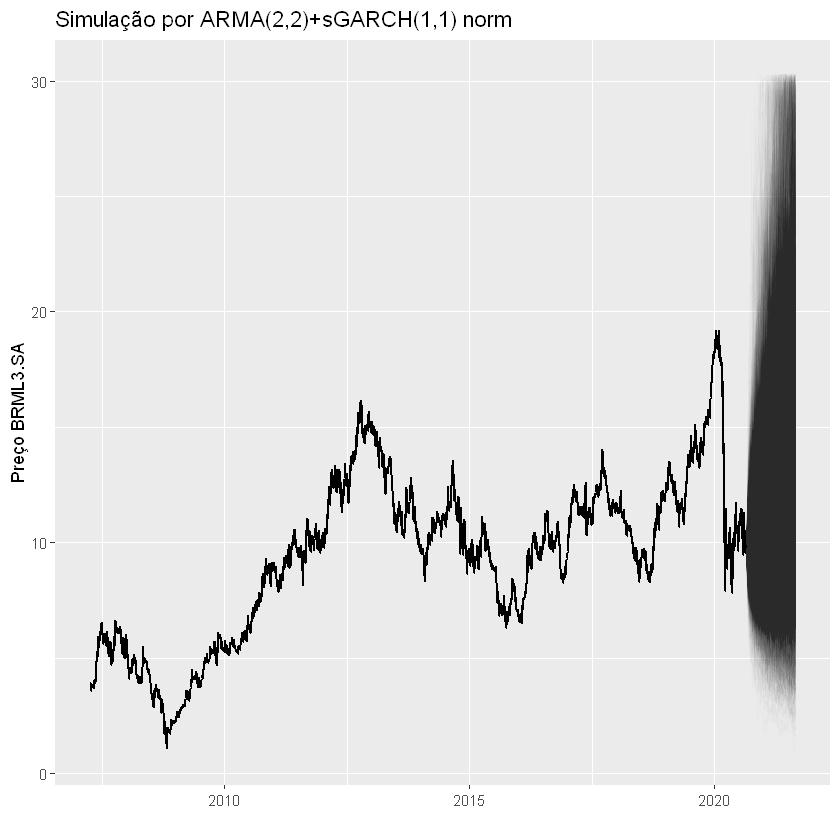

In [38]:
ggplot()+
  geom_line(data = ibov1, mapping = aes(x = ref.date, y = price.adjusted),
            size = 0.75)+
  geom_line(data = sim, mapping = aes(x = ref_date, y = sim_price, group = i_sim),
            size = 0.4,
            alpha = 0.01)+
  labs(x = "", y = paste("Preço", ibov1$series_name),
       title = paste("Simulação por",arch$best_aic$model_name))+
  ylim(min(sim$sim_price),quantile(sim$sim_price,0.99))

In [36]:
meta <- max(ibov1$price.adjusted)
tab_prob <- sim %>%
  group_by(ref_date) %>%
  summarise(prob = mean(sim_price > meta))
p <- tab_prob %>%
  filter(round(prob,2) == 0.5)
p <- p[1,]

`summarise()` ungrouping output (override with `.groups` argument)



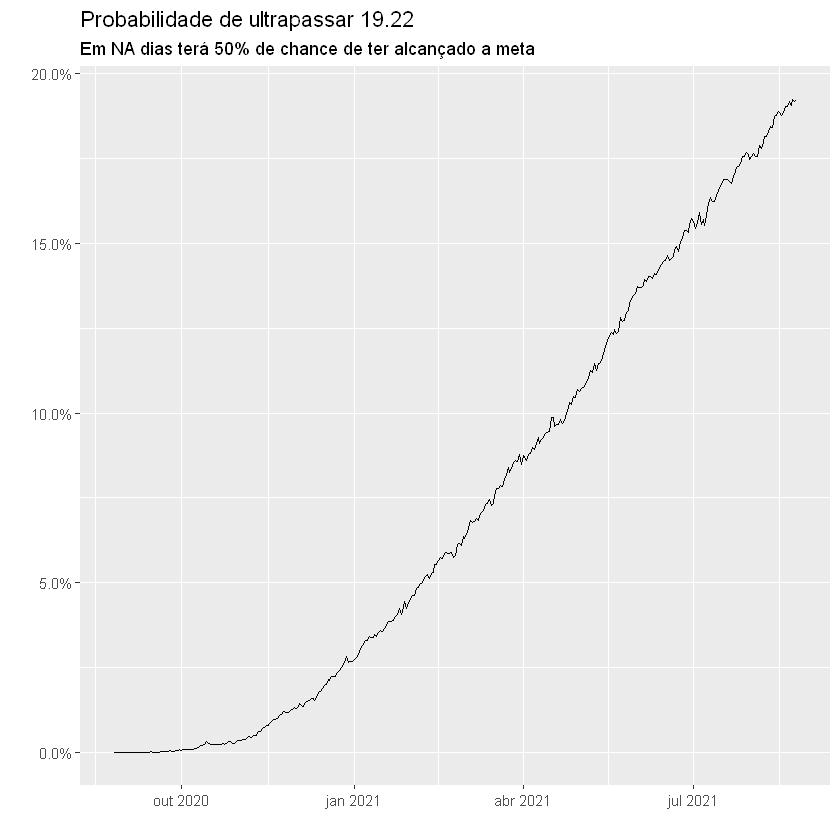

In [37]:
ggplot()+
  geom_line(data = tab_prob[2:nrow(tab_prob),], mapping = aes(x = ref_date, y = prob))+
  labs(x = "", y = "",
       title = paste("Probabilidade de ultrapassar",round(meta,2)),
       subtitle = paste("Em",p$ref_date-last(ibov1$ref.date),
                        "dias terá 50% de chance de ter alcançado a meta"))+
  scale_y_continuous(labels = scales::percent)+
  geom_hline(yintercept = p$prob)+
  geom_vline(xintercept = p$ref_date)+
  geom_point(aes(x = p$ref_date, y = p$prob), col = "red")